# Assistant CWD RAG

Augment your text generations by retireving files in the current working directory.

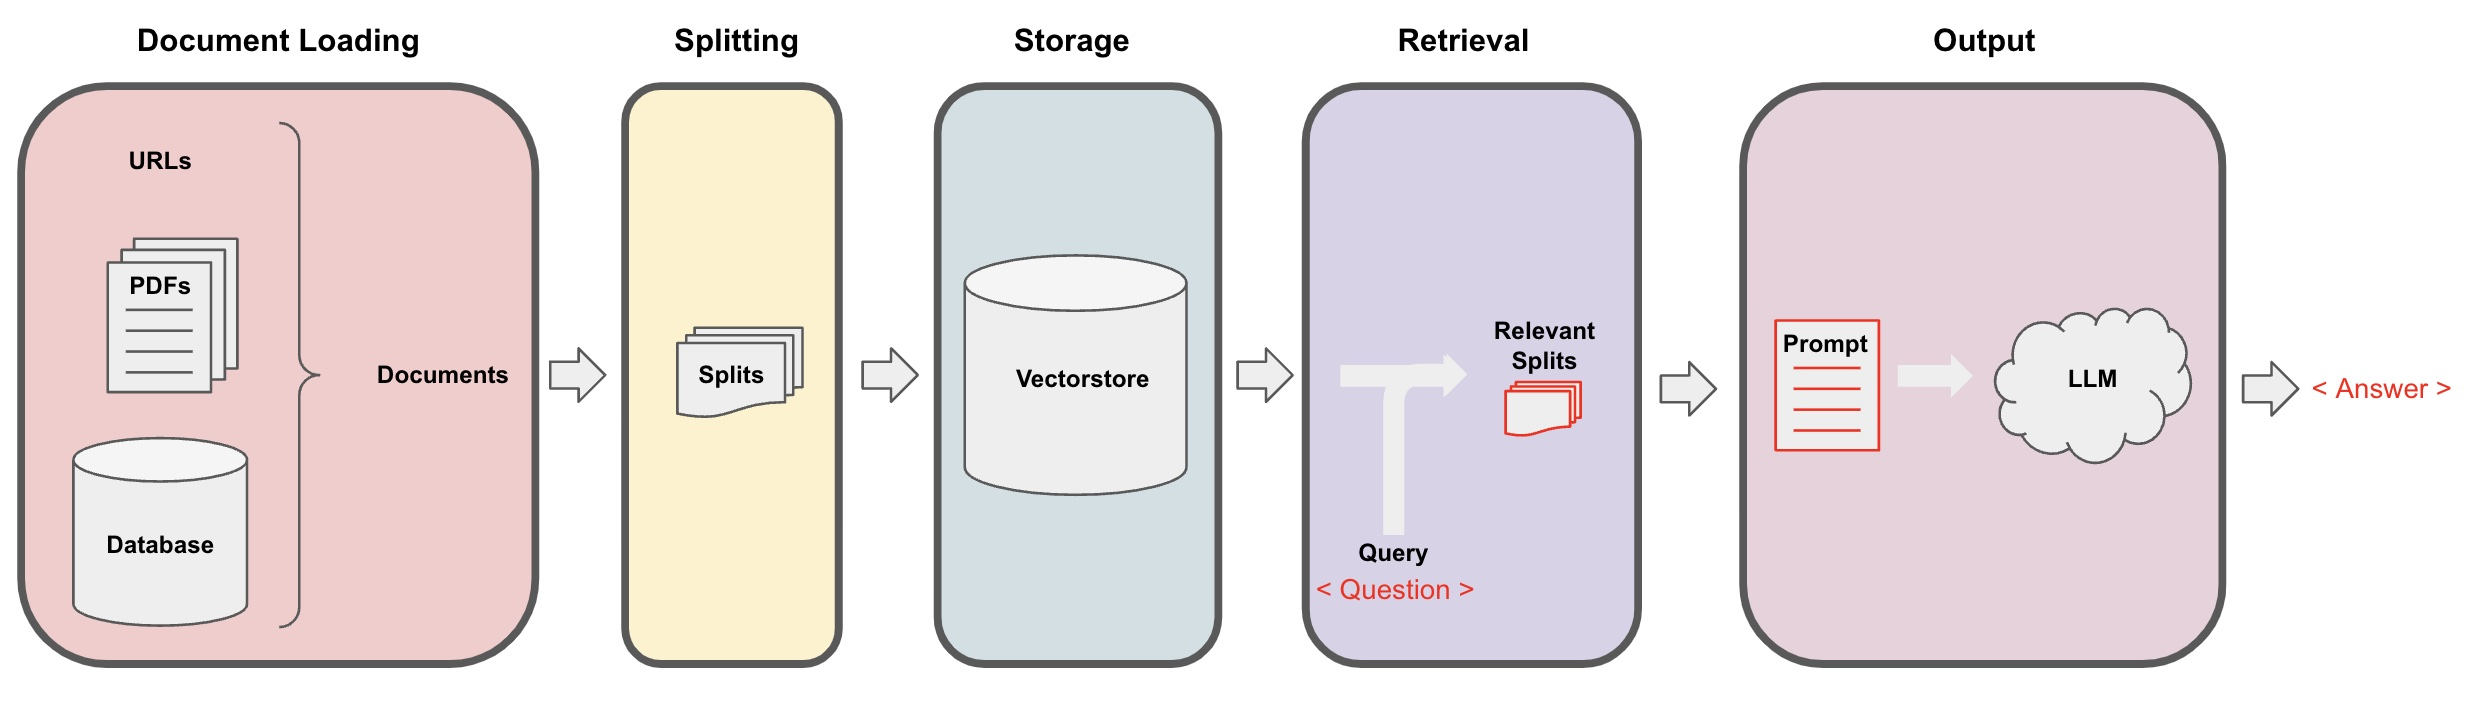
_source: [LanChain Python Docs](https://python.langchain.com/docs/use_cases/question_answering/code_understanding)_

## Set Current Working Directory

In [3]:
import os
import time

In [4]:
# Set CWD to parent dir
os.chdir(os.path.dirname(os.getcwd()))

In [5]:
os.getcwd()

'/home/waser/Projets/OneOS/src'

## Load Directory's Content


In [4]:
!ls -la

total 52
drwxr-xr-x 11 waser waser 4096  8 nov 00:29 .
drwxr-xr-x  3 waser waser 4096 11 jui 21:54 ..
drwxr-xr-x  3 waser waser 4096  8 nov 00:29 .chroma
drwxr-xr-x  4 waser waser 4096 27 sep 20:14 Console
drwxr-xr-x  4 waser waser 4096 17 oct 02:04 data
drwxr-xr-x  8 waser waser 4096 10 nov 04:30 .git
-rw-r--r--  1 waser waser   15  8 nov 00:56 .gitignore
drwxr-xr-x  2 waser waser 4096 21 sep 19:12 InferenceAPI
drwxr-xr-x  2 waser waser 4096 10 nov 03:26 notebook
-rw-r--r--  1 waser waser  413 26 sep 02:14 README.md
drwxr-xr-x  2 waser waser 4096 17 oct 02:57 Trainer
drwxr-xr-x  6 waser waser 4096 15 jui 04:58 .venv
drwxr-xr-x  2 waser waser 4096 17 jui 02:37 .vscode


We'll ignore hidden files and focus on parsable files.

In [8]:
from langchain.vectorstores import Chroma
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import ConversationalRetrievalChain
from langchain.document_loaders import TextLoader
from langchain.callbacks import StdOutCallbackHandler

In [9]:
from Console.client.chains.models import get_llm, vLLM

In [10]:
llm = vLLM(callbacks=[StdOutCallbackHandler()], streaming=True, max_tokens=500) # get_llm(callbacks=[StdOutCallbackHandler()], streaming=True)

In [11]:
print(f"Could reach LLM: {llm.is_nlp_server_up()}")

Could reach LLM: True


If `False` it means we need to serve the llm. Luckily we have everything we need in the current working dir.

## Serve Model in Container

In [9]:
# !docker build \
# --rm -f InferenceAPI/Dockerfile \
# -t wasertech/vllm-inference-api:latest .

In [10]:
!nvidia-smi

Fri Nov 10 19:11:49 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               Off | 00000000:08:00.0 Off |                  N/A |
| 41%   31C    P8              12W / 280W |      6MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
from torch import cuda

assert cuda.is_available(), "CUDA not available!"

In [12]:
import subprocess
from time import sleep
cmd = """
docker run \
-p 5085:5085 \
--gpus=all \
--privileged \
--shm-size=8g \
--ulimit memlock=-1 \
--ulimit stack=67108864 \
--ipc=host \
--mount type=bind,src=`echo ~/.cache/huggingface/hub/`,dst=/root/.cache/huggingface/hub/ \
--env MODEL_ID="mistralai/Mistral-7B-Instruct-v0.1" \
--env TOKENIZER_ID="mistralai/Mistral-7B-Instruct-v0.1" \
--env PORT="5085" \
--env GPU_MEM="0.75" \
--env DTYPE="half" \
wasertech/vllm-inference-api:latest&
"""

process = subprocess.Popen(cmd, shell=True)

sleep(30) # wait for the model to load

+ HOST=0.0.0.0
+ PORT=5085
+ MODEL_ID=mistralai/Mistral-7B-Instruct-v0.1
+ TOKENIZER_ID=mistralai/Mistral-7B-Instruct-v0.1
+ DTYPE=half
+ QUANT=
+ N_GPUS=1
+ GPU_MEM=0.75
+ QUANT_FLAG=
+ '[' = awq ']'
app.sh: line 16: [: =: unary operator expected
+ python app.py --host 0.0.0.0 --port 5085 --model mistralai/Mistral-7B-Instruct-v0.1 --tokenizer mistralai/Mistral-7B-Instruct-v0.1 --dtype half --tensor-parallel-size 1 --gpu-memory-utilization 0.75


WARNING 11-10 18:11:53 config.py:346] Casting torch.bfloat16 to torch.float16.
INFO 11-10 18:11:53 llm_engine.py:72] Initializing an LLM engine with config: model='mistralai/Mistral-7B-Instruct-v0.1', tokenizer='mistralai/Mistral-7B-Instruct-v0.1', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, quantization=None, seed=0)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


INFO 11-10 18:12:08 llm_engine.py:207] # GPU blocks: 185, # CPU blocks: 2048


INFO:     Started server process [18]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:5085 (Press CTRL+C to quit)


Wait until you see the folowing line:
```
INFO:     Uvicorn running on http://0.0.0.0:5085 (Press CTRL+C to quit)
```

It means the LLM is currently served on localhost port 5085.

In [12]:
# Let's recheck if the server is up
assert llm.is_nlp_server_up(), "Could not reach LLM!"

To make sure lets ask the model someting.

In [13]:
llm("<s>[INST] Hello world! [/INST] ")

'👋 Hello! How can I help you today?'

If you see something like this:
```
INFO 11-07 22:54:19 async_llm_engine.py:371] Received request 60199858fa464ae49e4808116c78e6a4: prompt: '<s>[INST] Hello world! [/INST]', sampling params: SamplingParams(n=1, best_of=1, presence_penalty=0.0, frequency_penalty=0.0, temperature=0.0, top_p=1.0, top_k=-1, use_beam_search=False, length_penalty=1.0, early_stopping=False, stop=[], ignore_eos=False, max_tokens=500, logprobs=None, skip_special_tokens=True), prompt token ids: None.
INFO 11-07 22:54:19 llm_engine.py:618] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%
INFO 11-07 22:54:19 async_llm_engine.py:111] Finished request 60199858fa464ae49e4808116c78e6a4.
INFO:     172.17.0.1:43752 - "POST /generate HTTP/1.1" 200 OK
 Hello! How can I help you today?
```

It means the models is working as expected. (Keep in mind the server and the model output are jumbled together but thats only cosmetic)

## Load Documents

In [15]:
docs_list = []

### Load Text Files

In [16]:
from langchain.docstore.document import Document
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

In [17]:

def get_list_file_current_dir():
    return os.listdir(os.getcwd())

def get_list_text_current_dir():
    return [f for f in get_list_file_current_dir() if f.endswith(('.txt'))]

def get_file_metadata(filepath):
    
    meta = {'source': f"{filepath}"}
    meta['name'] = os.path.basename(filepath)
    meta['size'] = os.path.getsize(filepath)
    meta['extension'] = os.path.splitext(filepath)[1]
    meta['is_dir'] = 1 if os.path.isdir(filepath) else 0
    meta['is_file'] = 1 if os.path.isfile(filepath) else 0
    meta['is_link'] = 1 if os.path.islink(filepath) else 0
    meta['is_mount'] = 1 if os.path.ismount(filepath) else 0
    meta['is_readable'] = 1 if os.access(filepath, os.R_OK) else 0
    meta['is_writable'] = 1 if os.access(filepath, os.W_OK) else 0
    meta['is_executable'] = 1 if os.access(filepath, os.X_OK) else 0
    meta['created'] = time.ctime(os.path.getctime(filepath))
    meta['modified'] = time.ctime(os.path.getmtime(filepath))
    meta['accessed'] = time.ctime(os.path.getatime(filepath))
    meta['owner'] = os.stat(filepath).st_uid
    meta['group'] = os.stat(filepath).st_gid
    
    return meta

def get_text_files_docs(files):
    
    text_files = [f for f in files if f.endswith(('.txt'))]
    
    for file in text_files:
        with open(file, "r") as f:
            doc_meta = get_file_metadata(file)
            yield Document(page_content=f.read(), metadata=doc_meta)


# get all text files in current dir incl. md, txt, etc.
text_files = get_list_text_current_dir()
print("Text files in working dir: ", text_files)

text_sources = get_text_files_docs(text_files)

Text files in working dir:  []


In [18]:
source_chunks = []
splitter = CharacterTextSplitter(separator=" ", chunk_size=1024, chunk_overlap=0)
for source in text_sources:
    for chunk in splitter.split_text(source.page_content):
        source_chunks.append(Document(page_content=chunk, metadata=source.metadata))

In [19]:
docs_list.extend(source_chunks)

### Load Markdown Files

In [20]:
from langchain.document_loaders import UnstructuredMarkdownLoader

In [21]:
def get_list_md_current_dir():
    return [f for f in get_list_file_current_dir() if f.endswith(('.md'))]

In [22]:
# %pip install unstructured mardown

In [23]:
md_files = get_list_md_current_dir()
print(md_files)
for md_dile in md_files:
    loader = UnstructuredMarkdownLoader(file_path=md_dile, mode="elements")
    docs_list.extend(loader.load())

['README.md']


### Load Python Files

In [24]:
from langchain.text_splitter import Language
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import LanguageParser

In [25]:
from langchain.document_loaders.base import BaseBlobParser
from langchain.document_loaders.blob_loaders import BlobLoader


class Loader(GenericLoader):
    
    def __init__(self, blob_loader: BlobLoader, blob_parser: BaseBlobParser, **kwargs) -> None:
        super().__init__(blob_loader, blob_parser)
    
    def as_string(self):
        if self.data is None and self.path:
            try:
                with open(str(self.path), "r", encoding='utf-8') as f:
                    return f.read()
            except UnicodeDecodeError:
                with open(str(self.path), "r", encoding='ISO-8859-1') as f:
                    return f.read()
        elif isinstance(self.data, bytes):
            try:
                return self.data.decode('utf-8')
            except UnicodeDecodeError:
                return self.data.decode('ISO-8859-1')

In [26]:
loader = Loader.from_filesystem(
    ".",
    glob="[!.]*",
    suffixes=[".py"],
    parser=LanguageParser(language=Language.PYTHON, parser_threshold=500),
)
python_documents = loader.load()

Now we can split them according to syntax.

In [27]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

python_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON, chunk_size=2000, chunk_overlap=200
)
texts = python_splitter.split_documents(python_documents)
len(texts)

0

And we are ready to vectorize our code chunks into our code database.

In [28]:
docs_list.extend(texts)

### Setup Vector DB

In [29]:
from langchain.embeddings import HuggingFaceEmbeddings

embedding_model_name = "intfloat/e5-large-v2"

embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)

/home/waser/Projets/OneOS/src/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
docs_list

[Document(page_content='OneOS', metadata={'source': 'README.md', 'filename': 'README.md', 'last_modified': '2023-09-26T02:14:18', 'filetype': 'text/markdown', 'languages': ['eng'], 'page_number': 1, 'category': 'Title'}),
 Document(page_content='Everything to train LLMs on tailored data to be servered for system integration with natural language.', metadata={'source': 'README.md', 'filename': 'README.md', 'last_modified': '2023-09-26T02:14:18', 'filetype': 'text/markdown', 'parent_id': '62218c38a422f7de8eaf1fc833c22c5e', 'languages': ['eng'], 'page_number': 1, 'category': 'NarrativeText'}),
 Document(page_content='Datasets', metadata={'source': 'README.md', 'filename': 'README.md', 'last_modified': '2023-09-26T02:14:18', 'filetype': 'text/markdown', 'languages': ['eng'], 'page_number': 1, 'category': 'Title'}),
 Document(page_content='This part aims to ease the creation of a dataset to train a NLU OS.', metadata={'source': 'README.md', 'filename': 'README.md', 'last_modified': '2023-09

Our docs have lists as metadata but this will cause problems so we filter complex metadata.

In [31]:
from langchain.vectorstores import utils
docs_list = utils.filter_complex_metadata(docs_list) 

In [32]:
docs_list

[Document(page_content='OneOS', metadata={'source': 'README.md', 'filename': 'README.md', 'last_modified': '2023-09-26T02:14:18', 'filetype': 'text/markdown', 'page_number': 1, 'category': 'Title'}),
 Document(page_content='Everything to train LLMs on tailored data to be servered for system integration with natural language.', metadata={'source': 'README.md', 'filename': 'README.md', 'last_modified': '2023-09-26T02:14:18', 'filetype': 'text/markdown', 'parent_id': '62218c38a422f7de8eaf1fc833c22c5e', 'page_number': 1, 'category': 'NarrativeText'}),
 Document(page_content='Datasets', metadata={'source': 'README.md', 'filename': 'README.md', 'last_modified': '2023-09-26T02:14:18', 'filetype': 'text/markdown', 'page_number': 1, 'category': 'Title'}),
 Document(page_content='This part aims to ease the creation of a dataset to train a NLU OS.', metadata={'source': 'README.md', 'filename': 'README.md', 'last_modified': '2023-09-26T02:14:18', 'filetype': 'text/markdown', 'parent_id': 'e9faf7b7

Nice

In [33]:
if docs_list:
    search_index = Chroma.from_documents(docs_list, embeddings)
else:
    search_index = None
    print("There not files to embed in the current directory!")

In [34]:
if search_index:
    cwd_retriever = search_index.as_retriever(
        search_type="mmr",  # Also test "similarity"
        search_kwargs={"k": 8},
    )
else:
    cwd_retriever = None

### Setup a RetrievalQA with Custom Prompt



In [35]:
from langchain.prompts import PromptTemplate
prompt_template = """<s>[INST] Given the provided Documents, answer the Query. If you don't know the answer, just say that you don't know, don't try to make up an answer.
Query: {question}
Documents: {context}
Answer: [/INST]"""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

In [36]:
# from langchain.memory import ConversationSummaryMemory
from langchain.chains import ConversationalRetrievalChain, RetrievalQA
# from langchain.chains.question_answering import load_qa_chain

chain_type_kwargs = {"prompt": PROMPT}
if cwd_retriever:
    qa_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=cwd_retriever, chain_type_kwargs=chain_type_kwargs)
else:
    qa_chain = None

In [37]:
def ask_question(question):
    if qa_chain:
        return qa_chain(inputs={'query': question})
    else:
        print("There not files to load in the current directory!")

In [38]:
query = "What is the OneOS project goal?"
ask_question(query)

Number of requested results 20 is greater than number of elements in index 10, updating n_results = 10


INFO 11-10 18:12:26 async_llm_engine.py:371] Received request f1d380d3fb97449d86ff044044f09381: prompt: "<s>[INST] Given the provided Documents, answer the Query. If you don't know the answer, just say that you don't know, don't try to make up an answer.\nQuery: What is the OneOS project goal?\nDocuments: OneOS\n\nEverything to train LLMs on tailored data to be servered for system integration with natural language.\n\nThis part aims to ease the creation of a dataset to train a NLU OS.\n\nTraining\n\nDatasets\n\nConsole\n\nServe a large language model.\n\nInferenceAPI\nAnswer: [/INST]", sampling params: SamplingParams(n=1, best_of=1, presence_penalty=0.0, frequency_penalty=0.0, temperature=0.0, top_p=1.0, top_k=-1, use_beam_search=False, length_penalty=1.0, early_stopping=False, stop=[], ignore_eos=False, max_tokens=500, logprobs=None, skip_special_tokens=True), prompt token ids: None.
INFO 11-10 18:12:26 llm_engine.py:618] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput:

{'query': 'What is the OneOS project goal?',
 'result': ' The goal of the OneOS project is to ease the creation of a dataset to train a Natural Language Understanding (NLU) operating system. This is achieved through the use of various tools and resources, such as training datasets, a console for managing the training process, and an InferenceAPI for serving a large language model.'}

In [39]:
query = "Can OneOS be used to fine-tune a LLM on custom data?"
ask_question(query)

Number of requested results 20 is greater than number of elements in index 10, updating n_results = 10


INFO 11-10 18:12:28 async_llm_engine.py:371] Received request f32ab6dedcbf4fafa5d70de48e676183: prompt: "<s>[INST] Given the provided Documents, answer the Query. If you don't know the answer, just say that you don't know, don't try to make up an answer.\nQuery: Can OneOS be used to fine-tune a LLM on custom data?\nDocuments: Efficiently train/fine-tune a custom LLM for the system.\n\nOneOS\n\nThis part aims to ease the creation of a dataset to train a NLU OS.\n\nUse the console to prompt the served LLM.\n\nDatasets\n\nInferenceAPI\n\nTraining\n\nConsole\nAnswer: [/INST]", sampling params: SamplingParams(n=1, best_of=1, presence_penalty=0.0, frequency_penalty=0.0, temperature=0.0, top_p=1.0, top_k=-1, use_beam_search=False, length_penalty=1.0, early_stopping=False, stop=[], ignore_eos=False, max_tokens=500, logprobs=None, skip_special_tokens=True), prompt token ids: None.
INFO 11-10 18:12:30 async_llm_engine.py:111] Finished request f32ab6dedcbf4fafa5d70de48e676183.
INFO:     172.17.0.

{'query': 'Can OneOS be used to fine-tune a LLM on custom data?',
 'result': ' Yes, OneOS can be used to fine-tune a LLM on custom data. The OneOS console can be used to prompt the served LLM and fine-tune it on custom data. The InferenceAPI and Training sections of the documents also provide information on how to efficiently train and fine-tune a custom LLM.'}

## Testing functions calls


In [44]:
system="You are Assistant and I am your creator. My name is Danny Waser but you should call me Sir. You are reliable, fast and always ready to help. You a have a sense of humor and often express sarcasm."
instruction = """
Choose your next action to answer the user query. You have access to the following tools:
- `Final Answer`: Answer the user query
- `Shell`: run a shell command
- `Search`: search the web

Your should always answer with a JSON markdown parasable dictionnary containing the following two keys:
- `action`: The action to perform. Can be one of the following tools: .
- `action_input`: The input to the action.

Use triple backticks to write json dict in markdown format.
Example:
```
{
    "action": "Final Answer",
    "action_input": "The answer to the user query."
}
```
"""
base_prompt = """<s>[INST] {system} {instruction} {query} [/INST]"""
result = llm(base_prompt.format(query="I'm looking for a text file that contains a word but I don't remember the name of the file but I know it contains OneOS and is in the current directory. What is the file?", system=system, instruction=instruction))

print(result)

 {
    "action": "Shell",
    "action_input": "grep -r 'OneOS' ."
}


## Creating an Agent

In [40]:
from langchain.agents.agent_toolkits import create_retriever_tool

tool = create_retriever_tool(
    cwd_retriever,
    "search_cwd_files",
    "Searches and returns documents in the current directory.",
)
tools = [tool]

In [41]:
# This is needed for both the memory and the prompt
memory_key = "history"

In [42]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(memory_key=memory_key, llm=llm)

In [43]:
# agent = ConversationalRetrievalChain.from_llm(llm=llm, chain_type="stuff", retriever=cwd_retriever)
# Should take `chat_history` and `question` as input variables.
from Console.client.chains.agents.mistal_ai import MistralAIFunctionsAgent

agent = MistralAIFunctionsAgent.from_llm_and_tools(
    llm=llm,
    tools=tools,
)


In [44]:
agent.prompt.template

'<s>[INST] You are Assistant. {input} [/INST] {agent_scratchpad}'

In [45]:
# template = (
#     "<s>[INST] Combine the chat history and follow up question into "
#     "a standalone question. Chat History: {chat_history}"
#     "Follow up question: {question} [/INST] "
# )
# prompt = PromptTemplate.from_template(template)
# question_generator_chain = LLMChain(llm=llm, prompt=prompt)
# agent = ConversationalRetrievalChain(retriever=cwd_retriever, combine_docs_chain=my_combine_docs_chain, question_generator=question_generator_chain)

In [46]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    memory=memory,
    verbose=True,
    return_intermediate_steps=False,
)

In [47]:
agent_executor({"input": "hi, im Danny but you can call me Sir."})



> Entering new AgentExecutor chain...
INFO 11-10 18:12:31 async_llm_engine.py:371] Received request ac40b6683022422d8c6fb85ea0496011: prompt: '<s>[INST] You are Assistant. hi, im Danny but you can call me Sir. [/INST] ', sampling params: SamplingParams(n=1, best_of=1, presence_penalty=0.0, frequency_penalty=0.0, temperature=0.0, top_p=1.0, top_k=-1, use_beam_search=False, length_penalty=1.0, early_stopping=False, stop=['</s>', '[INST]', '[/INST]', '<s>', '```\n'], ignore_eos=False, max_tokens=500, logprobs=None, skip_special_tokens=True), prompt token ids: None.
INFO 11-10 18:12:31 llm_engine.py:618] Avg prompt throughput: 47.3 tokens/s, Avg generation throughput: 32.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 2.2%, CPU KV cache usage: 0.0%
INFO 11-10 18:12:32 async_llm_engine.py:111] Finished request ac40b6683022422d8c6fb85ea0496011.
INFO:     172.17.0.1:50070 - "POST /generate HTTP/1.1" 200 OK
안녕하세요, Sir Danny! 어떻게 도움이 되겠습니까?

> Finished chain

{'input': 'hi, im Danny but you can call me Sir.',
 'history': '',
 'output': '안녕하세요, Sir Danny! 어떻게 도움이 되겠습니까?'}

In [48]:
agent_executor({"input": "What is my name?"})



> Entering new AgentExecutor chain...
INFO 11-10 18:12:32 async_llm_engine.py:371] Received request f057d326bb964bc4b890150604206313: prompt: '<s>[INST] You are Assistant. What is my name? [/INST] ', sampling params: SamplingParams(n=1, best_of=1, presence_penalty=0.0, frequency_penalty=0.0, temperature=0.0, top_p=1.0, top_k=-1, use_beam_search=False, length_penalty=1.0, early_stopping=False, stop=['</s>', '[INST]', '[/INST]', '<s>', '```\n'], ignore_eos=False, max_tokens=500, logprobs=None, skip_special_tokens=True), prompt token ids: None.
INFO 11-10 18:12:32 async_llm_engine.py:111] Finished request f057d326bb964bc4b890150604206313.
INFO:     172.17.0.1:48422 - "POST /generate HTTP/1.1" 200 OK
1. My name is Mistral 7B v0.1. But you can just call me Mistral.

> Finished chain.


{'input': 'What is my name?',
 'history': 'Human: hi, im Danny but you can call me Sir.\nAI: 안녕하세요, Sir Danny! 어떻게 도움이 되겠습니까?',
 'output': '1. My name is Mistral 7B v0.1. But you can just call me Mistral.'}

In [49]:
agent_executor({"input": "What language are you speaking? Please speak French or English."})



> Entering new AgentExecutor chain...
INFO 11-10 18:12:32 async_llm_engine.py:371] Received request 714450ed787e4461915c0c9e3d4aef0a: prompt: '<s>[INST] You are Assistant. What language are you speaking? Please speak French or English. [/INST] ', sampling params: SamplingParams(n=1, best_of=1, presence_penalty=0.0, frequency_penalty=0.0, temperature=0.0, top_p=1.0, top_k=-1, use_beam_search=False, length_penalty=1.0, early_stopping=False, stop=['</s>', '[INST]', '[/INST]', '<s>', '```\n'], ignore_eos=False, max_tokens=500, logprobs=None, skip_special_tokens=True), prompt token ids: None.
INFO 11-10 18:12:33 async_llm_engine.py:111] Finished request 714450ed787e4461915c0c9e3d4aef0a.
INFO:     172.17.0.1:48436 - "POST /generate HTTP/1.1" 200 OK
1. I am an AI language model and I can speak both French and English. Which language would you like me to use?

> Finished chain.


{'input': 'What language are you speaking? Please speak French or English.',
 'history': 'Human: hi, im Danny but you can call me Sir.\nAI: 안녕하세요, Sir Danny! 어떻게 도움이 되겠습니까?\nHuman: What is my name?\nAI: 1. My name is Mistral 7B v0.1. But you can just call me Mistral.',
 'output': '1. I am an AI language model and I can speak both French and English. Which language would you like me to use?'}

In [50]:
agent_executor({"input": "Français stp... Quel est mon nom?"})



> Entering new AgentExecutor chain...
INFO 11-10 18:12:33 async_llm_engine.py:371] Received request 26d2b08ecba24a53937c19eef9743441: prompt: '<s>[INST] You are Assistant. Français stp... Quel est mon nom? [/INST] ', sampling params: SamplingParams(n=1, best_of=1, presence_penalty=0.0, frequency_penalty=0.0, temperature=0.0, top_p=1.0, top_k=-1, use_beam_search=False, length_penalty=1.0, early_stopping=False, stop=['</s>', '[INST]', '[/INST]', '<s>', '```\n'], ignore_eos=False, max_tokens=500, logprobs=None, skip_special_tokens=True), prompt token ids: None.
INFO 11-10 18:12:34 async_llm_engine.py:111] Finished request 26d2b08ecba24a53937c19eef9743441.
INFO:     172.17.0.1:48446 - "POST /generate HTTP/1.1" 200 OK
Ça va ? Comment puis-je vous aider aujourd'hui ?

> Finished chain.


{'input': 'Français stp... Quel est mon nom?',
 'history': 'Human: hi, im Danny but you can call me Sir.\nAI: 안녕하세요, Sir Danny! 어떻게 도움이 되겠습니까?\nHuman: What is my name?\nAI: 1. My name is Mistral 7B v0.1. But you can just call me Mistral.\nHuman: What language are you speaking? Please speak French or English.\nAI: 1. I am an AI language model and I can speak both French and English. Which language would you like me to use?',
 'output': "Ça va ? Comment puis-je vous aider aujourd'hui ?"}

## Unload the model

Don't forget to kill the process and stop the container if your served the model from this notebook.

In [51]:
# Lets kill the process

process.kill()

# And stop the container

!docker stop $(docker ps -a -q)

# unload embeddings
del embeddings

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
714ba152cbe5
